In [6]:
import tools
import visualization_2D as vis2D
import visualization_3D as vis3D
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import random as rd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
from intermine.webservice import Service

# I- TRN download

In [2]:
#Sun et al., 2019
#https://wiley.figshare.com/ndownloader/files/14670236
Yeast_TRN = pd.read_csv('../results/Yeast_TRN.csv', sep='\t')
Yeast_TRN

,TF,TG,Direction,Distance
0,YLR403W,YLR048W,+,118.474
1,YDR423C,YKL002W,-,129.335
2,YMR021C,YDL234C,-,66.365
3,YLR403W,YDR050C,?,156.673
4,YDR253C,YLR438W,bound,109.636
...,...,...,...,...
28255,YIL101C,YOR070C,binding enriched,62.813
28256,YER159C,YBR203W,binding enriched,70.405
28257,YDR392W,YLR258W,binding enriched,124.902
28258,YML027W,YKR093W,+,46.923


In [ ]:
service = Service("https://yeastmine.yeastgenome.org/yeastmine/service")

# Get a new query on the class (table) you will be querying:
query = service.new_query("Gene")

# Type constraints should come early - before all mentions of the paths they constrain
query.add_constraint("regulatoryRegions", "TFBindingSite")

# The view specifies the output columns
query.add_view(
    "regulatoryRegions.regulator.symbol",
    "regulatoryRegions.regulator.secondaryIdentifier", "symbol",
    "secondaryIdentifier", "regulatoryRegions.regEvidence.ontologyTerm.name",
    "regulatoryRegions.regEvidence.ontologyTerm.identifier",
    "regulatoryRegions.experimentCondition",
    "regulatoryRegions.strainBackground",
    "regulatoryRegions.regulationDirection",
    "regulatoryRegions.publications.pubMedId", "regulatoryRegions.datasource",
    "regulatoryRegions.annotationType"
)

# Uncomment and edit the line below (the default) to select a custom sort order:
# query.add_sort_order("Gene.regulatoryRegions.regulator.symbol", "ASC")

# You can edit the constraint values below
query.add_constraint("regulatoryRegions.regulator", "IN", "Verified_ORFs", code="A")
query.add_constraint("regulatoryRegions.strainBackground", "=", "S288c", code="B")
#query.add_constraint("regulatoryRegions.experimentCondition", "==", "cellular response to heat", code="C")

# Uncomment and edit the code below to specify your own custom logic:
# query.set_logic("B and A and C and C")

In [ ]:
query_list = []

for row in query.rows():
    query_list += [row["regulatoryRegions.regulator.symbol"],
        row["regulatoryRegions.regulator.secondaryIdentifier"], row["symbol"],
        row["secondaryIdentifier"], row["regulatoryRegions.regEvidence.ontologyTerm.name"],
        row["regulatoryRegions.regEvidence.ontologyTerm.identifier"], \
        row["regulatoryRegions.experimentCondition"], row["regulatoryRegions.strainBackground"],
        row["regulatoryRegions.regulationDirection"], \
        row["regulatoryRegions.publications.pubMedId"], row["regulatoryRegions.datasource"],
        row["regulatoryRegions.annotationType"])]

# II- Targets lists creation

## 1) All targets

In [ ]:
list_TF = Yeast_TRN.TF.unique()
#len(list_TF) = 186

for TF in list_TF :
    
    TG = Yeast_TRN[Yeast_TRN.TF == TF]
    TG = TG.drop(["TF", "Distance"], axis = 1)
    TG.to_csv("../results/TF_target_TRN/" + str(TF) + "_" + str(len(TG)) + "_targets.csv", 
              index = False, 
              columns = ["TG", "Direction"])

## 2) Targets filtered by type of regulation (+/-)

In [ ]:
list_TF = Yeast_TRN.TF.unique()
#len(list_TF) = 186

for TF in list_TF :
    
    TG = Yeast_TRN[Yeast_TRN.TF == TF]
    TG = TG.drop(["TF", "Distance"], axis = 1)
    TG = TG[TG.Direction == "+"]
    TG.to_csv("../results/TF_target_TRN_pos/" + str(TF) + "_" + str(len(TG)) + "_pos_targets.csv", 
              index = False, 
              columns = ["TG", "Direction"])

for TF in list_TF :
    
    TG = Yeast_TRN[Yeast_TRN.TF == TF]
    TG = TG.drop(["TF", "Distance"], axis = 1)
    TG = TG[TG.Direction == "-"]
    TG.to_csv("../results/TF_target_TRN_neg/" + str(TF) + "_" + str(len(TG)) + "_neg_targets.csv", 
              index = False, 
              columns = ["TG", "Direction"])

## 3) Activated targets filtered by GO terms

In [ ]:
files_names = os.listdir("../results/TF_target_TRN_pos")

for genes in files_names:
    genes_list = pd.read_csv('../results/TF_target_TRN_pos/' + genes, sep=',', header = [0])
        
    if len(genes_list.TG) >= 50 :
        genes_list.to_csv("../results/TF_target_TRN_pos_for_SGD_GOterms/" + genes, 
                          index = False, header = False, columns = ["TG"])


# III- Figures generation functions

## 1) Targets repartition on the chromosomes

In [3]:
def chrom_repartition_hist(genes_list):
    
    sql_query = \
"""SELECT Primary_SGDID, Feature_name, Start_coordinate, Stop_coordinate, Chromosome, Strand
FROM SGD_features
ORDER BY Start_coordinate
"""
    
    loci = tools.get_locus_info("../SCERE.db", sql_query)
    loci = loci.assign(FT_target = loci.Feature_name.isin(genes_list))
       
    loci = loci[loci.FT_target == True].drop(["FT_target"], axis = 1)
       
    fig = px.histogram(loci, x="Chromosome", nbins=30, range_x=[1, 17], color_discrete_sequence=['#A0E8AF'])
    fig.update_layout(plot_bgcolor = "white",
                      xaxis_showgrid = False,
                      yaxis_showgrid = False, 
                      showlegend = True)
       
    return fig

## 2) 3D distances between targets

In [4]:
def distances_hist(genes_list):
    
    sql_query = \
"""SELECT Primary_SGDID, Chromosome, Feature_name, Strand, Stop_coordinate, Start_coordinate
FROM SGD_features
"""

    Feature_name = tools.get_locus_info("../SCERE.db", sql_query)
    Feature_name = Feature_name.merge(genes_list, left_on = "Feature_name", right_on = genes_list.columns[0])
    
    adjacency_matrix_select = adjacency_matrix.loc[Feature_name.Primary_SGDID, Feature_name.Primary_SGDID]
    adjacency_matrix_select.index.names = ["Primary_SGDID_bis"]
    
    edges_list = adjacency_matrix_select.stack().dropna().reset_index()
    edges_list = edges_list.sort_values(by = "Primary_SGDID_bis")
    edges_list.rename(columns = {0: "3D_distances"}, inplace = True)
    edges_list = edges_list.sort_values(by = "3D_distances")
    edges_list.index = range(1, len(edges_list) + 1)
    
    fig = px.histogram(edges_list, x="3D_distances", range_x=[-10, 210], nbins= 70, color_discrete_sequence=['#A0E8AF'])
    fig.update_layout(plot_bgcolor = "white", 
                      xaxis_showgrid = False, 
                      yaxis_showgrid = False, 
                      showlegend = True)
    
    return fig

# IV- Results

## 1) All targets together

In [ ]:
adjacency_matrix = pd.read_parquet("../dashboard/static/adjacency_matrix.parquet.gzip", engine='pyarrow')
files_names = os.listdir("../results/TF_target_TRN")

#removed mitochondrial targets genes :
#Q0050, Q0080 and Q0120 from YIR018W_451_targets
#Q0115 and Q0130 from YJL127C_1176_targets
#Q0080 and Q0297 from 'YEL009C_303_targets.csv'


for genes in files_names:
    genes_list = pd.read_csv('../results/TF_target_TRN/' + genes, sep=',', header = [0])
        
    chrom_repartition = chrom_repartition_hist(genes_list.TG)
    distances = distances_hist(genes_list)
    
    chrom_repartition.write_image("../results/chrom_repartition_hist/" + genes +".jpeg")
    distances.write_image("../results/3Ddistances_hist/" + genes +".jpeg")

## 2) Activated targets

In [ ]:
adjacency_matrix = pd.read_parquet("../dashboard/static/adjacency_matrix.parquet.gzip", engine='pyarrow')
files_names = os.listdir("../results/TF_target_TRN_pos")

for genes in files_names:
    genes_list = pd.read_csv('../results/TF_target_TRN_pos/' + genes, sep=',', header = [0])
        
    if len(genes_list.TG) > 0 :    
        chrom_repartition = chrom_repartition_hist(genes_list.TG)
        distances = distances_hist(genes_list)
        
        chrom_repartition.write_image("../results/chrom_repartition_hist_pos/" + genes +".jpeg")
        distances.write_image("../results/3Ddistances_hist_pos/" + genes +".jpeg")

# V- Random targets lists creation

In [ ]:
list_all_TG = Yeast_TRN.TG.unique()
list_all_TG = list(list_all_TG)
for mito_gene in ["Q0050", "Q0080","Q0120", "Q0115", "Q0130", "Q0297"] :
    print(mito_gene)
    list_all_TG.remove(mito_gene)

list_TF = Yeast_TRN.TF.unique()

for TF in list_TF :
    
    TG = Yeast_TRN[Yeast_TRN.TF == TF]
    TG = TG.drop(["TF", "Distance"], axis = 1)
    
    random_TG = pd.DataFrame(data = {"random_TG": rd.choices(list_all_TG, k=len(TG))})
    random_TG.to_csv("../results/TF_random_target_TRN/" + str(TF) + "_" + str(len(TG)) + "_random_targets.csv", 
                     index = False, 
                     columns = ["random_TG"])


In [ ]:
adjacency_matrix = pd.read_parquet("../dashboard/static/adjacency_matrix.parquet.gzip", engine='pyarrow')
files_names = os.listdir("../results/TF_random_target_TRN")

for genes in files_names:
    genes_list = pd.read_csv('../results/TF_random_target_TRN/' + genes, sep=',', header = [0])
        
    chrom_repartition = chrom_repartition_hist(genes_list.random_TG)
    distances = distances_hist(genes_list)
        
    chrom_repartition.write_image("../results/random/" + genes +".jpeg")
    distances.write_image("../results/random/" + genes +".jpeg")

# V- QQ plots

In [24]:
def distances_QQplot(genes_list, random_genes_list, adjacency_matrix, genes):
    
    edges_list = get_edges_list(genes_list, adjacency_matrix)
    x = np.array(edges_list["3D_distances"])
    
    random_edges_list = get_edges_list(random_genes_list, adjacency_matrix)
    y = np.array(random_edges_list["3D_distances"])
    
    pp_x = sm.ProbPlot(x)
    print(x)
    pp_y = sm.ProbPlot(y)
    print(y)
    qqplot_2samples(pp_x, pp_y)
    plt.xlabel('genes list 3D distances')
    plt.ylabel('random list 3D distances')
    
    genes = genes[:-4]
    plt.savefig("../results/QQplots/" + genes + ".jpeg")
    plt.close()

    return

def get_edges_list(gene_list, adjacency_matrix):
    
    sql_query = \
"""SELECT Primary_SGDID, Chromosome, Feature_name, Strand, Stop_coordinate, Start_coordinate
FROM SGD_features
"""

    Feature_name = tools.get_locus_info("../SCERE.db", sql_query)
    Feature_name = Feature_name.merge(genes_list, left_on = "Feature_name", right_on = genes_list.columns[0])
    
    adjacency_matrix_select = adjacency_matrix.loc[Feature_name.Primary_SGDID, Feature_name.Primary_SGDID]
    adjacency_matrix_select.index.names = ["Primary_SGDID_bis"]
    
    edges_list = adjacency_matrix_select.stack().dropna().reset_index()
    edges_list = edges_list.sort_values(by = "Primary_SGDID_bis")
    edges_list.rename(columns = {0: "3D_distances"}, inplace = True)
    edges_list = edges_list.sort_values(by = "3D_distances")
    edges_list.index = range(1, len(edges_list) + 1)
    
    return edges_list

[6.61759020e-02 7.37783844e-02 9.02413431e-02 ... 1.98704910e+02
 1.98725630e+02 1.98822470e+02]
[6.61759020e-02 7.37783844e-02 9.02413431e-02 ... 1.98704910e+02
 1.98725630e+02 1.98822470e+02]
[1.05361283e-01 1.12649345e-01 8.90882708e-01 ... 1.86326125e+02
 1.86348781e+02 1.87038356e+02]
[1.05361283e-01 1.12649345e-01 8.90882708e-01 ... 1.86326125e+02
 1.86348781e+02 1.87038356e+02]
[  1.69667763  12.13656834  12.52382601  13.66191096  23.4582727
  32.04051225  32.98844649  33.66637916  38.14289454  42.96002324
  44.87008064  50.54359162  51.90770368  55.86237874  56.12371383
  57.82293844  62.60731831  63.66445768  66.4282862   68.63948858
  70.88976062  74.79707847  75.52566691  77.56609864  78.86034282
  80.82680155  80.9208924   83.45129107  86.27669429  87.87714504
  88.22810964  88.42703216  88.83589543  89.62445582  89.83418689
  91.14838228  93.65751016  94.43247876  97.002924    97.89134301
 101.67674431 105.45284368 107.76679708 109.0022353  115.88081113
 117.7472558  118.1

[  0.4228534   63.87949913  64.26954854  64.59399964  67.80899779
  68.38291502  68.54496762  84.2001891   85.39075778  88.12075901
  97.06403071 105.03990146 105.43126808 106.85196732 107.08109959]
[  0.4228534   63.87949913  64.26954854  64.59399964  67.80899779
  68.38291502  68.54496762  84.2001891   85.39075778  88.12075901
  97.06403071 105.03990146 105.43126808 106.85196732 107.08109959]
[6.61759020e-02 1.00424101e-01 1.05055937e-01 ... 1.84260818e+02
 1.84934348e+02 1.86166078e+02]
[6.61759020e-02 1.00424101e-01 1.05055937e-01 ... 1.84260818e+02
 1.84934348e+02 1.86166078e+02]
[1.44245547e-01 1.48198441e-01 1.72482608e-01 ... 1.80895043e+02
 1.85029300e+02 1.89433641e+02]
[1.44245547e-01 1.48198441e-01 1.72482608e-01 ... 1.80895043e+02
 1.85029300e+02 1.89433641e+02]
[1.25057320e-01 1.36740224e-01 1.44149999e-01 ... 1.97760017e+02
 1.97936321e+02 1.97938075e+02]
[1.25057320e-01 1.36740224e-01 1.44149999e-01 ... 1.97760017e+02
 1.97936321e+02 1.97938075e+02]
[1.15753090e-01 1.44

[1.43664540e-01 2.15070337e-01 2.27203103e-01 ... 1.84081663e+02
 1.84520330e+02 1.86104477e+02]
[1.43664540e-01 2.15070337e-01 2.27203103e-01 ... 1.84081663e+02
 1.84520330e+02 1.86104477e+02]


KeyboardInterrupt: 

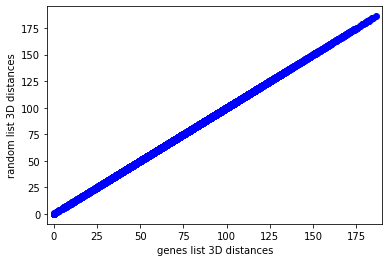

In [25]:
adjacency_matrix = pd.read_parquet("../dashboard/static/adjacency_matrix.parquet.gzip", engine='pyarrow')
files_names = os.listdir("../results/TF_target_TRN")
files_names_random = os.listdir("../results/TF_random_target_TRN")


for genes,random_genes in zip(files_names, files_names_random):
    random_genes_list = pd.read_csv('../results/TF_random_target_TRN/' + random_genes, sep=',', header = [0])
    genes_list = pd.read_csv('../results/TF_target_TRN/' + genes, sep=',', header = [0])
    
    distances_QQplot(genes_list, random_genes_list, adjacency_matrix, genes)

# VI- Distributions comparaison

In [19]:
def ks_2samples(sample, random_sample, name):
    
    sample_chrom_repartition = chrom_repartition(sample.TG)
    random_chrom_repartition = chrom_repartition(random_sample.random_TG)
    
    ks_result = ks_2samp(sample_chrom_repartition, random_chrom_repartition)
    
    if ks_result.pvalue < 0.05:
        print(name)
        print(ks_result)
    
    return



def chrom_repartition(genes_list):
    
    sql_query = \
"""SELECT Primary_SGDID, Feature_name, Start_coordinate, Stop_coordinate, Chromosome, Strand
FROM SGD_features
ORDER BY Start_coordinate
"""
    
    loci = tools.get_locus_info("../SCERE.db", sql_query)
    loci = loci.assign(FT_target = loci.Feature_name.isin(genes_list))
       
    loci = loci[loci.FT_target == True].drop(["FT_target"], axis = 1)
       
    return loci.Chromosome

In [20]:
files_names = os.listdir("../results/TF_target_TRN")
files_names_random = os.listdir("../results/TF_random_target_TRN")


for genes, random_genes in zip(files_names, files_names_random):
    random_genes_list = pd.read_csv('../results/TF_random_target_TRN/' + random_genes, sep=',', header = [0])
    genes_list = pd.read_csv('../results/TF_target_TRN/' + genes, sep=',', header = [0])
    
    ks_2samples(genes_list, random_genes_list, genes)

YCR081W_29_targets.csv
KstestResult(statistic=0.40157723828668623, pvalue=0.00017985772415118895)
YOR140W_6_targets.csv
KstestResult(statistic=0.5580865603644647, pvalue=0.029143814490225295)
YCR084C_444_targets.csv
KstestResult(statistic=0.8806306306306306, pvalue=0.02992895651735772)
YGL181W_43_targets.csv
KstestResult(statistic=0.3801613668723303, pvalue=0.0017205834492300953)
YHR206W_69_targets.csv
KstestResult(statistic=0.45362318840579713, pvalue=0.03625423913055148)
YOL148C_406_targets.csv
KstestResult(statistic=0.15901387445202694, pvalue=0.022686464704800957)
YOR380W_10_targets.csv
KstestResult(statistic=0.4965250965250965, pvalue=0.009382370195694323)
YPL007C_2_targets.csv
KstestResult(statistic=0.9206989247311828, pvalue=0.013170916026413737)
YHL027W_69_targets.csv
KstestResult(statistic=0.2255031734718121, pvalue=0.0038686862358362495)
YNL236W_387_targets.csv
KstestResult(statistic=0.23698071953885907, pvalue=0.009424259845130512)
YBR240C_24_targets.csv
KstestResult(statist